## SD

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import os

# Paths
demo_save_path = "/home/yuxuanli/failed_IRL_new/FL/models/successful_demonstrations_200.pkl"
model_save_path = "/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SD_500.pth"

# Check if CUDA is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the neural kernel regression model
class NeuralKernelRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralKernelRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Predicts the weight

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Function to preprocess the transitions and compute weights
def prepare_data(successful_demos, exp_k=1.0):
    states = []
    weights = []
    
    for traj in successful_demos:
        demo_length = len(traj)
        for i, (obs, act, reward, next_obs, terminated, truncated, success) in enumerate(traj):
            # Use only obs as the state representation
            flat_trans = obs.flatten()
            weight = (i + 1) / demo_length * np.exp(exp_k * (i + 1) / demo_length)
            states.append(flat_trans)
            weights.append(weight)
    
    # Convert to numpy arrays
    states = np.array(states)
    weights = np.array(weights).reshape(-1, 1)
    
    return states, weights

# Load the successful demonstrations
if os.path.exists(demo_save_path):
    with open(demo_save_path, "rb") as f:
        successful_demos = pickle.load(f)
else:
    raise FileNotFoundError(f"{demo_save_path} not found. Run demonstration collection first.")

# Prepare data for training
states, weights = prepare_data(successful_demos)

# Convert data to PyTorch tensors and move them to the device (GPU if available)
states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

# Initialize and train the neural kernel regression model
input_dim = states_tensor.shape[1]
hidden_dim = 64
model = NeuralKernelRegression(input_dim, hidden_dim).to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
# num_epochs = 500
# for epoch in range(num_epochs):
#     optimizer.zero_grad()
#     predictions = model(states_tensor)
#     loss = criterion(predictions, weights_tensor)
#     loss.backward()
#     optimizer.step()
    
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item()}")

# Save the trained model
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

# To load the model later:
model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

Using device: cuda:0


NeuralKernelRegression(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_success_reward(success_model, device="cuda:0"):
    # Set up grid world parameters
    lake_size = 4
    grid_resolution = 100  # Defines how many points to sample along each axis
    grid_points = np.linspace(0, lake_size, grid_resolution)
    
    # Create a grid of points covering the entire lake
    xv, yv = np.meshgrid(grid_points, grid_points)
    grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point
    
    # Convert grid states to tensor and add necessary padding for model input if needed
    grid_states_tensor = torch.tensor(grid_states, dtype=torch.float32).to(device)
    
    # Set the model to evaluation mode
    success_model.eval()
    
    # Predict the reward using the model for each grid point
    with torch.no_grad():
        success_reward = success_model(grid_states_tensor).cpu().numpy().reshape(grid_resolution, grid_resolution)
    
    # Visualization of the reward function
    plt.figure(figsize=(8, 6))
    plt.contourf(xv, yv, success_reward, levels=50, cmap='RdYlGn')
    plt.colorbar(label="Reward")
    plt.title("Reward Function Map (Using Successful Demos Only)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

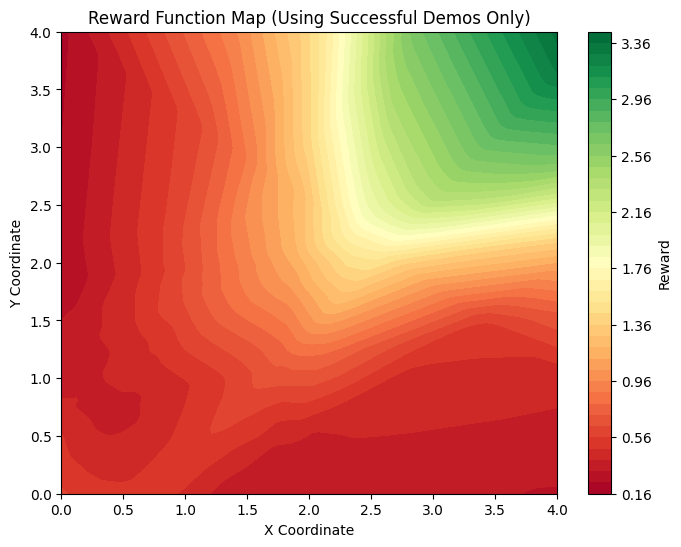

In [30]:
# Load the trained model for successful demonstrations
input_dim = 2  # Assuming only `obs` with two coordinates (x, y)
hidden_dim = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

success_model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
success_model.load_state_dict(torch.load("/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SD_500.pth"))

# Visualize the reward function
visualize_success_reward(success_model, device=device)

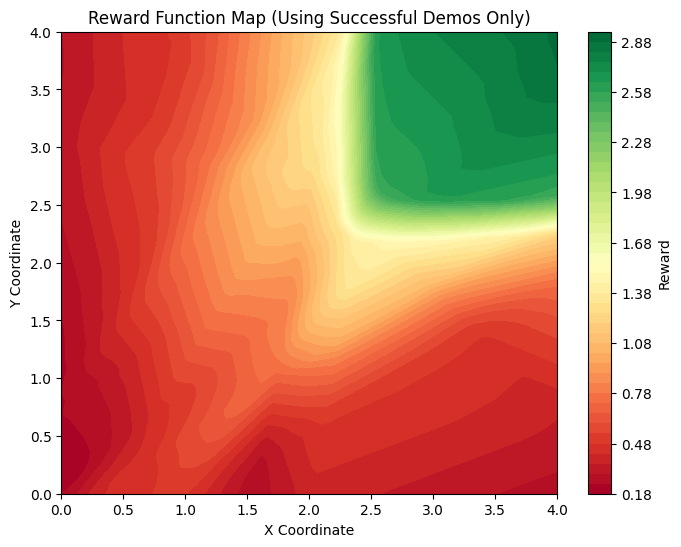

In [31]:
# Load the trained model for successful demonstrations
input_dim = 2  # Assuming only `obs` with two coordinates (x, y)
hidden_dim = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

success_model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
success_model.load_state_dict(torch.load("/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SD_1000.pth"))

# Visualize the reward function
visualize_success_reward(success_model, device=device)

## SD only with state And new Agent

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import os

# Paths
demo_save_path = "/home/yuxuanli/failed_IRL_new/FL/models/successful_demonstrations_200.pkl"
model_save_path = "/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SD_1000.pth"

# Check if CUDA is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the neural kernel regression model
class NeuralKernelRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralKernelRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Predicts the weight

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Function to preprocess the transitions and compute weights
def prepare_data(successful_demos, exp_k=1.0):
    states = []
    weights = []
    
    for traj in successful_demos:
        demo_length = len(traj)
        for i, (obs, act, reward, next_obs, done, success) in enumerate(traj):
            # Use only the obs (state) as the input feature
            flat_trans = obs.flatten()
            weight = (i + 1) / demo_length * np.exp(exp_k * (i + 1) / demo_length)
            states.append(flat_trans)
            weights.append(weight)
    
    # Convert to numpy arrays
    states = np.array(states)
    weights = np.array(weights).reshape(-1, 1)
    
    return states, weights

# Load the successful demonstrations
if os.path.exists(demo_save_path):
    with open(demo_save_path, "rb") as f:
        successful_demos = pickle.load(f)
else:
    raise FileNotFoundError(f"{demo_save_path} not found. Run demonstration collection first.")

# Prepare data for training
states, weights = prepare_data(successful_demos)

# Convert data to PyTorch tensors and move them to the device (GPU if available)
states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

# Initialize and train the neural kernel regression model
input_dim = states_tensor.shape[1]
hidden_dim = 64
model = NeuralKernelRegression(input_dim, hidden_dim).to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()



Using device: cuda:0


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_success_reward(success_model, device="cuda:0"):
    # Set up grid world parameters
    lake_size = 4
    grid_resolution = 100  # Defines how many points to sample along each axis
    grid_points = np.linspace(0, lake_size, grid_resolution)
    
    # Create a grid of points covering the entire lake
    xv, yv = np.meshgrid(grid_points, grid_points)
    grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point

    # Convert grid states to tensor and move them to the device
    grid_states_tensor = torch.tensor(grid_states, dtype=torch.float32).to(device)
    
    # Set the model to evaluation mode
    success_model.eval()
    
    # Predict the reward using the model for each grid point
    with torch.no_grad():
        success_reward = success_model(grid_states_tensor).cpu().numpy().reshape(grid_resolution, grid_resolution)
    
    # Visualization of the reward function
    plt.figure(figsize=(8, 6))
    plt.contourf(xv, yv, success_reward, levels=50, cmap='RdYlGn')
    plt.colorbar(label="Reward")
    plt.title("Reward Function Map (Using Successful Demos Only)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

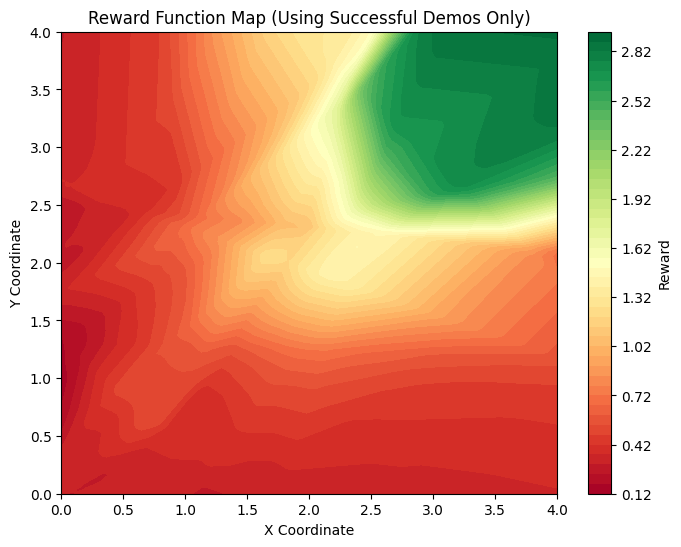

In [34]:
# Load the trained model for successful demonstrations
input_dim = 2  # Assuming only `obs` with two coordinates (x, y)
hidden_dim = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

success_model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
success_model.load_state_dict(torch.load("/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SD_1000.pth"))

# Visualize the reward function
visualize_success_reward(success_model, device=device)

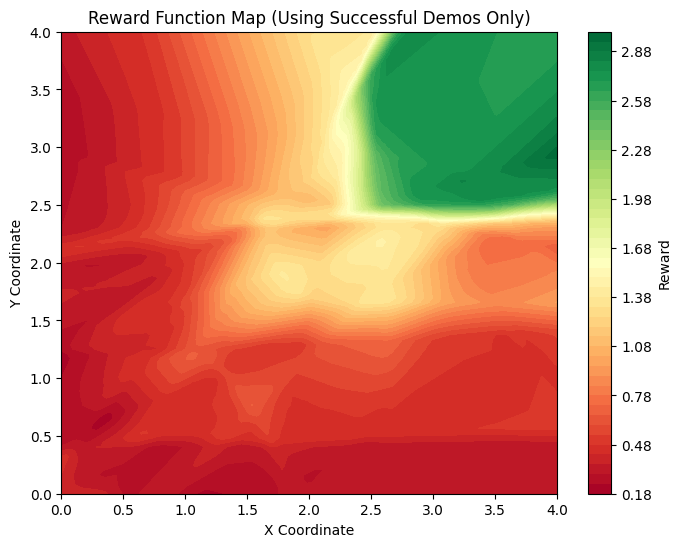

In [35]:
# Load the trained model for successful demonstrations
input_dim = 2  # Assuming only `obs` with two coordinates (x, y)
hidden_dim = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

success_model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
success_model.load_state_dict(torch.load("/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SD_5000.pth"))

# Visualize the reward function
visualize_success_reward(success_model, device=device)

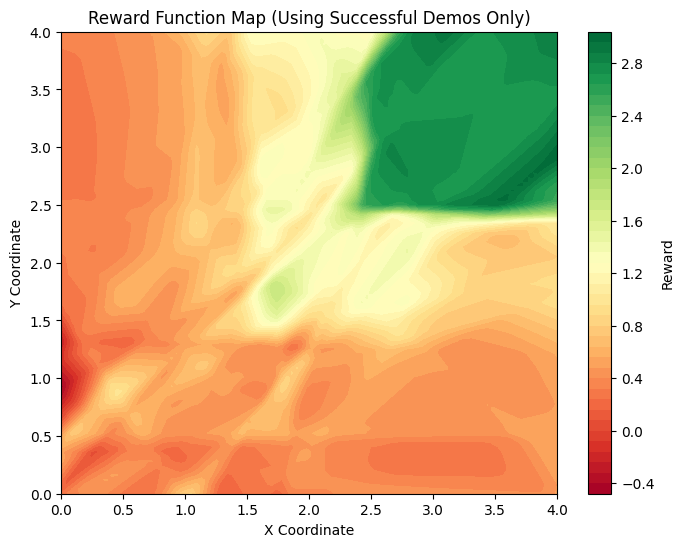

In [36]:
# Load the trained model for successful demonstrations
input_dim = 2  # Assuming only `obs` with two coordinates (x, y)
hidden_dim = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

success_model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
success_model.load_state_dict(torch.load("/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SD_10000.pth"))

# Visualize the reward function
visualize_success_reward(success_model, device=device)

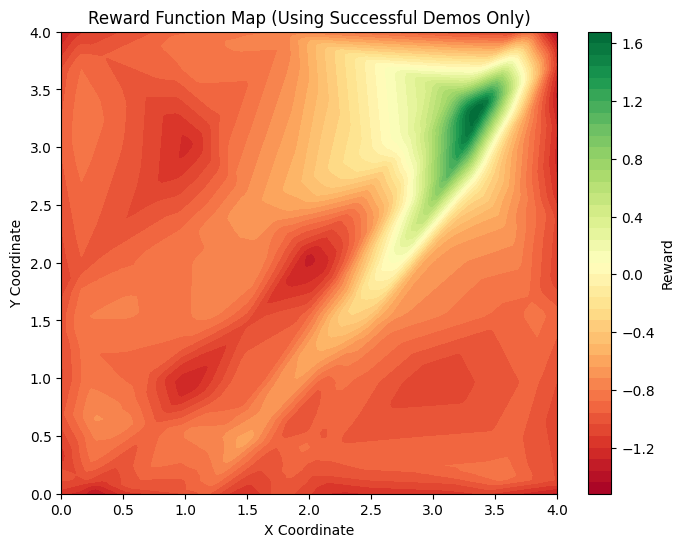

In [38]:
# Load the trained model for successful demonstrations
input_dim = 2  # Assuming only `obs` with two coordinates (x, y)
hidden_dim = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

success_model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
success_model.load_state_dict(torch.load("/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SFD_1000.pth"))

# Visualize the reward function
visualize_success_reward(success_model, device=device)

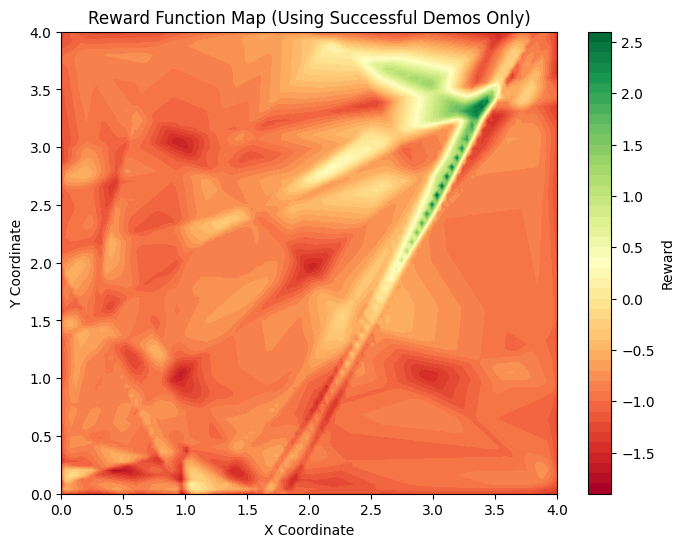

In [39]:
# Load the trained model for successful demonstrations
input_dim = 2  # Assuming only `obs` with two coordinates (x, y)
hidden_dim = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

success_model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
success_model.load_state_dict(torch.load("/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SFD_100000.pth"))

# Visualize the reward function
visualize_success_reward(success_model, device=device)

In [ ]:
# SFO
# Load the trained model for successful demonstrations
input_dim = 2  # Assuming only `obs` with two coordinates (x, y)
hidden_dim = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

success_model = NeuralKernelRegression(input_dim, hidden_dim).to(device)
success_model.load_state_dict(torch.load("/home/yuxuanli/failed_IRL_new/Deep_Model/KR_Deep_Model_SFD_100000.pth"))

# Visualize the reward function
visualize_success_reward(success_model, device=device)

## Try Gaussian Kernel with deep f(x), (not only f(x))